# 1.Imports

In [1]:
import re
import yaml
import torch
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt

from kaituoxu.conv_tasnet import ConvTasNet
from asteroid.data import MUSDB18Dataset

In [4]:
DATA_DIR = Path("musdb_data")
TEST_SONG = DATA_DIR/"test/Al James - Schoolboy Facination.stem.mp4"

EXP_DIR = Path("experiment_results/exp-1")
exps = [e for e in EXP_DIR.iterdir() if e.is_dir()]

histories = [exp/"history.csv" for exp in exps]

cfgs = []
for exp in exps:

    cfg = list(exp.glob("*.yaml"))[0]
    with open(str(cfg), "r") as f:
        cfg = yaml.load(f, Loader=yaml.FullLoader)
        cfgs.append(cfg)

## Hyper parameters:

In [5]:
for i, cfg in enumerate(cfgs):
    print("CFG file n0", i, "\n")
    for key, value in cfg.items():
        print(f">>> {key.upper()} -> {value}")
    print("\n")

CFG file n0 0 

>>> SAMPLE_RATE -> 16000
>>> SIZE -> -1
>>> LEARNING_RATE -> 0.001
>>> N_EPOCHS -> 100
>>> TRAIN_BATCH_SIZE -> 2
>>> TEST_BATCH_SIZE -> 64
>>> SEGMENT_SIZE -> 1
>>> RANDOM_TRACK_MIX -> False
>>> TARGETS -> ['drums', 'bass', 'other', 'vocals']
>>> X -> 8
>>> R -> 3
>>> B -> 128
>>> H -> 512
>>> SC -> 128
>>> P -> 3
>>> L -> 16
>>> N -> 512
>>> STRIDE -> 8
>>> LOSS -> pairwise_mse
>>> STORE_GRADIENT_NORM -> True
>>> VERBOSE -> 0
>>> GRADIENT_CLIPPING -> 5
>>> SAVE_WEIGHTS_EACH_EPOCH -> False


CFG file n0 1 

>>> SAMPLE_RATE -> 8000
>>> SIZE -> -1
>>> LEARNING_RATE -> 0.001
>>> N_EPOCHS -> 100
>>> TRAIN_BATCH_SIZE -> 2
>>> TEST_BATCH_SIZE -> 64
>>> SEGMENT_SIZE -> 1
>>> RANDOM_TRACK_MIX -> False
>>> TARGETS -> ['drums', 'bass', 'other', 'vocals']
>>> X -> 8
>>> R -> 3
>>> B -> 128
>>> H -> 512
>>> SC -> 128
>>> P -> 3
>>> L -> 16
>>> N -> 512
>>> STRIDE -> 8
>>> LOSS -> pairwise_mse
>>> STORE_GRADIENT_NORM -> True
>>> VERBOSE -> 0
>>> GRADIENT_CLIPPING -> 5
>>> SAVE_WEIGH

# 2. Learning Curves

In [6]:
labels = [""] * len(exps)

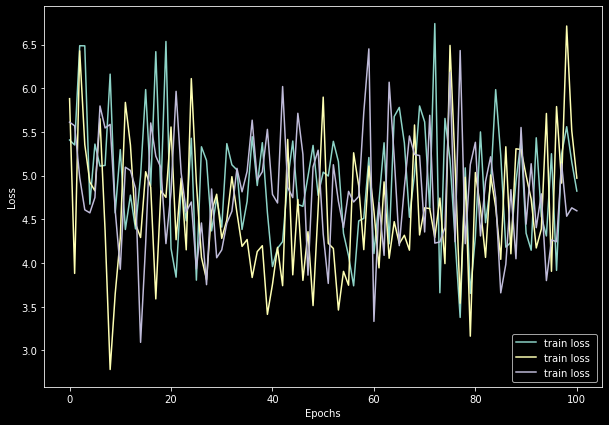

In [10]:
plt.figure(figsize=(10, 7))
for i, exp in enumerate(exps):
    history = pd.read_csv(exp/"history.csv")
    plt.plot(history.epoch, history.train_loss, label="train loss " + labels[i])
    #plt.plot(history.epoch, history.val_loss, label="val loss" + labels[i])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.plot();

## Observations :


# 3. Load model

In [28]:
i = 0

CFG = cfgs[i]
TARGETS = CFG["targets"]
SAMPLE_RATE = CFG["sample_rate"]

LR = CFG["learning_rate"]
N_EPOCHS = CFG["n_epochs"]

TRAIN_BATCH_SIZE = CFG["train_batch_size"]
TEST_BATCH_SIZE = CFG["test_batch_size"]

N_SRC = len(TARGETS)
X = CFG["X"]
R = CFG["R"]
B = CFG["B"]
H = CFG["H"]
Sc = CFG["Sc"]
P = CFG["P"]
L = CFG["L"]
N = CFG["N"]
STRIDE = CFG["stride"]
CLIP = CFG["gradient_clipping"]

model = ConvTasNet(
    C=N_SRC,
    X=X,
    R=R,
    B=B,
    H=H,
    P=P,
    L=L,
    N=N,
    stride=STRIDE,
    mask_nonlinear="softmax"
)
model.load_state_dict(torch.load(exps[i]/"model.pth")["model_state_dict"])

<All keys matched successfully>

In [29]:
TARGETS

['drums', 'bass', 'other', 'vocals']

# 4. Separation test

In [ ]:
sound, sr = librosa.load(TEST_SONG.__str__(), sr=SAMPLE_RATE)

In [ ]:
sound = torch.tensor(sound[:10 * SAMPLE_RATE])

In [ ]:
pred = model(sound.view(1, -1))

In [ ]:
pred.shape

In [ ]:
for i, name in enumerate(TARGETS):
    wavfile.write(f"./{name}.wav", SAMPLE_RATE, pred[i].detach().numpy())